# Application of ResNet CycleGAN on Style Transfer Task

Style transfer is a computer vision technique that "re-paint" the images with the visual style of another. Traditionally, machine learning models need a pair of images - a real photo and its artistic variation - to learn the styles and apply it to new photos. Nevertheless, it's very challenging and expensive to collect image pairs in real life. For instance, it's almost not possible to collect enough image pairs for model training to transfer the art styles of some famous artists to real photos. Generative adversarial network (GAN) uses the ideas of zero-sum game, where one network (generator) generates fake images to fool another network (discriminator) and discriminator aims to identify the fake images and provide feedback to the generator. The goal of training this model generate fake images which successfully fool the discriminator. However, it's not sufficient to use this model for image-image translation tasks, e.g. style transfer. With the development of deep learning algorithms, an extension of generative adversarial network (GAN) named CycleGAN has been designed to enable image-image translation and style transfer between unrelated images. CycleGAN uses two generators to generate images from the first domain to the second and generate images from the second domain to the first respectively. Each generator is also paired with a discriminator to provide feedback on the generated images for updating generators. Beyond generator and discriminator loss, CycleGAN also introduces two new losses: cycle consistency loss and identity loss. The intuition of the cycle consistency loss is that an image that's translated from one domain to another and then translated back to the original domain is expected to be similar to the original image. On the other hand, identity loss is introduced to discourage the model to translate the images that are already in the correct domain. In this study, a CycleGAN is implemented to transfer the art style of Monet to photos. 300 Monet paintings and 7038 photos are fed to CycleGAN for model training. Each painting or photo has 256 $\times$ 256 pixels and 3 color channels. All paintings and photos have the same file format - jpg. Generated images are evaluated with Memorization-informed Fréchet Inception Distance (MiFID).

### Citation

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

## Exploratory Data Analysis

In [1]:
# import library
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from PIL import Image
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, ReLU, LeakyReLU, Flatten, Dropout, BatchNormalization, Reshape, Activation, Concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import plot_model
from google.colab import drive
from google.colab import files

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-fws90n0b
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-fws90n0b
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=7c6f2a5c28d22feba08cf1bf39a9960b36ab8ed1164c095ecb3bd352c362f503
  Stored in directory: /tmp/pip-ephem-wheel-cache-2jua6wuk/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [2]:
# Mount google drive and upload data
drive.mount('/gdrive', force_remount = True)
image_path = '/gdrive/MyDrive/week5_project/gan-getting-started.zip'
local_path = '/content'
!cp '{image_path}' .
os.chdir(local_path)
!unzip -q 'gan-getting-started.zip' -d '/content/images'

Mounted at /gdrive


In [3]:
monet_painting_lst = os.listdir(os.path.join(local_path, 'images', 'monet_jpg'))
photo_lst = os.listdir(os.path.join(local_path, 'images', 'photo_jpg'))
print('Number of Monet images：', len(monet_painting_lst))
print('Number of photos：', len(photo_lst))

Number of Monet images： 300
Number of photos： 7038


In [ ]:
# check image resolution
def loading_img(file_name_lst, folder_name):
    img_lst = []
    for file_name in file_name_lst:
        img_path = os.path.join(local_path, 'images', folder_name, file_name)
        img = Image.open(img_path)
        img = np.asarray(img) / 255.0
        img_lst.append(img)
    return np.array(img_lst)

painting_array = loading_img(monet_painting_lst, 'monet_jpg')
photo_array = loading_img(photo_lst, 'photo_jpg')

print('Dimension of painting array:', painting_array.shape, '\n'
      'Dimension of photo array:', photo_array.shape)

Dimension of painting array: (300, 256, 256, 3) 
Dimension of photo array: (7038, 256, 256, 3)


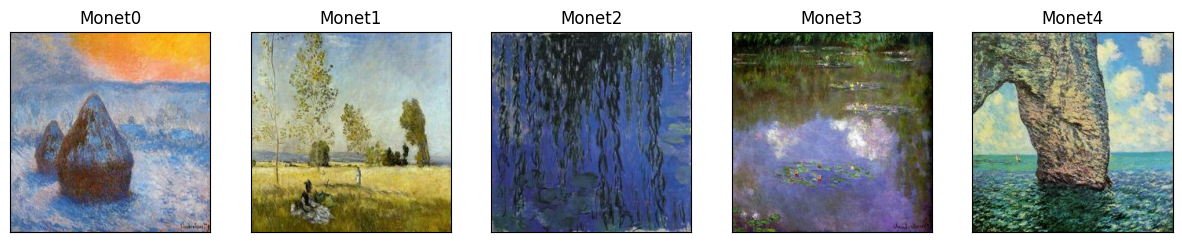

In [ ]:
# display images
random.seed(42)
def display_img(img_array, n_sample, title):
    f, ax = plt.subplots(1, n_sample, figsize = (15, 15))
    for i in range(n_sample):
        ind = random.randint(0, img_array.shape[0])
        img_rn = img_array[ind]
        ax[i].imshow(img_rn)
        ax[i].title.set_text(title + str(i))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

display_img(painting_array, 5, 'Monet')

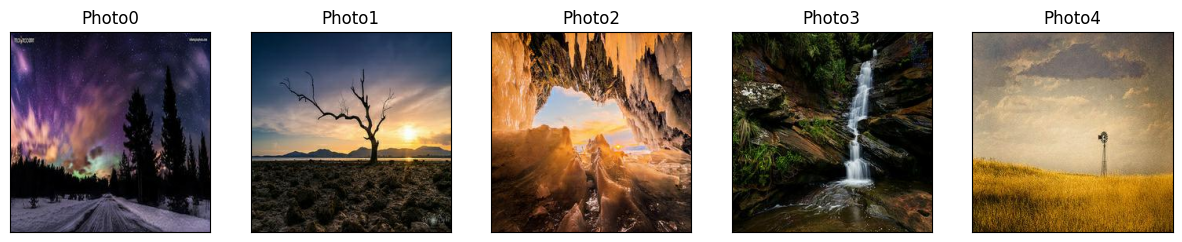

In [ ]:
random.seed(42)
display_img(photo_array, 5, 'Photo')

In [ ]:
# loading data
painting_data = keras.utils.image_dataset_from_directory(
    directory = os.path.join(local_path, 'images', 'monet_jpg'),
    label_mode = None,
    image_size = (256, 256),
    shuffle = False,
    batch_size = 1
)
painting_data = painting_data.map(lambda x: x/255.0)

photo_data = keras.utils.image_dataset_from_directory(
    directory = os.path.join(local_path, 'images', 'photo_jpg'),
    label_mode = None,
    image_size = (256, 256),
    shuffle = False,
    batch_size = 1
)
photo_data = photo_data.map(lambda x: x/255.0)

Five Monet paintings and five real photos are displayed to gain the basic understanding of our training data. It's clear that Monet paintings and photos have different contents, colors, contrasts, etc. Each image has 256 $\times$ 256 pixels and three color channels. To achieve a higher computational efficiency, all images are normalized and scaled down to 1 $\times$ 1 squared images.

## CycleGAN Training and Analysis

CycleGAN is a deep learning algorithm developed for image-to-image translation tasks without the need for paired data. The model simultaneously train two generators and discriminators and uses cycle consistency loss to overcome the challenge of missing paired images. Two adversary loss (generator loss, discriminator loss) and identity loss will also be calculated during the training process. Identity loss is introduced to regularize the generator such that the output image will have the expected style if the input image is already stylized. Theoretically, a deeper neural network is expected to have a better performance. However, this is not always the case in practice and gradient might vanishes by passing through multiple layers. In this study, a skip connection approach named ResNet is implemented between encoders and decoders to preserve the information that might be lost.

In [4]:
# Autoencoder
def downsample(filters, size, apply_instancenorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    model = keras.Sequential()
    model.add(Conv2D(filters, size, strides=2, padding='same',kernel_initializer=init, use_bias=False))

    if apply_instancenorm:
        model.add(InstanceNormalization(axis = -1))

    model.add(LeakyReLU(alpha = 0.2))

    return model

def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)

    model = keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
    model.add(InstanceNormalization(axis = -1))

    if apply_dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())

    return model

In [7]:
# Residual block
def resnet_block(input_layer, n_filters):
	init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

	model = Conv2D(n_filters, (4,4), padding='same', kernel_initializer=init)(input_layer)
	model = InstanceNormalization(axis=-1)(model)
	model = Activation('relu')(model)
	model = Conv2D(n_filters, (4,4), padding='same', kernel_initializer=init)(model)
	model = InstanceNormalization(axis=-1)(model)
	model = Concatenate()([model, input_layer])

	return model

In [8]:
# Generator
def define_generator(n_resnet = 9):
    input_img = keras.layers.Input(shape = [256, 256, 3])
    model = downsample(64, 4, apply_instancenorm=False)(input_img)
    model = downsample(128, 4)(model)
    model = downsample(256, 4)(model)

    for _ in range(n_resnet):
        model = resnet_block(model, 256)

    up1 = upsample(128, 4, apply_dropout = True)(model)
    up2 = upsample(64, 4, apply_dropout = True)(up1)

    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    output = Conv2DTranspose(3, kernel_size = 4, strides = 2, padding='same', kernel_initializer=init)(up2)
    output = InstanceNormalization(axis=-1)(output)
    output_img = Activation('tanh')(output)

    model = Model(input_img, output_img)
    return model

In [9]:
# discriminator
def define_discriminator():
    input_img = keras.layers.Input(shape = [256, 256, 3])
    model = downsample(64, 4, apply_instancenorm=False)(input_img)
    model = downsample(128, 4)(model)
    model = downsample(256, 4)(model)

    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    model = Conv2D(512, 3, padding='same', kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    output_patch = Conv2D(1, 3, padding='same', kernel_initializer=init)(model)

    model = Model(input_img, output_patch)
    return model

In [13]:
monet_generator1 = define_generator()
photo_generator1 = define_generator()
monet_discriminator1 = define_discriminator()
photo_discriminator1 = define_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [14]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [15]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5


def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [16]:
# training model
monet_generator_opt1 = Adam(2e-5, beta_1=0.5)
photo_generator_opt1 = Adam(2e-5, beta_1=0.5)

monet_discriminator_opt1 = Adam(2e-5, beta_1=0.5)
photo_discriminator_opt1 = Adam(2e-5, beta_1=0.5)

cycle_gan_model1 = CycleGan(
    monet_generator1, photo_generator1, monet_discriminator1, photo_discriminator1
)

cycle_gan_model1.compile(
    m_gen_optimizer = monet_generator_opt1,
    p_gen_optimizer = photo_generator_opt1,
    m_disc_optimizer = monet_discriminator_opt1,
    p_disc_optimizer = photo_discriminator_opt1,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [108]:
# function that displays input photo and generated image
def style_transfer_img(m_generator):
    f, ax = plt.subplots(3, 2, figsize=(8, 8))
    for i, img in enumerate(photo_data.take(3)):
        pred = m_generator(img, training=False)[0].numpy()
        pred = (pred* 255).astype(np.uint8)
        img = (img[0] * 255).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(pred)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet Style")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")

In [18]:
cycle_gan_model1.fit(
    tf.data.Dataset.zip((painting_data, photo_data)),
    epochs=30
)

Epoch 1/30
300/300 [==============================] - 181s 401ms/step - monet_gen_loss: 11.3614 - photo_gen_loss: 10.7898 - monet_disc_loss: 0.3341 - photo_disc_loss: 0.4079
Epoch 2/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 11.3632 - photo_gen_loss: 10.5835 - monet_disc_loss: 0.0789 - photo_disc_loss: 0.1166
Epoch 3/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 12.0050 - photo_gen_loss: 11.0362 - monet_disc_loss: 0.0408 - photo_disc_loss: 0.0639
Epoch 4/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 12.3776 - photo_gen_loss: 11.3287 - monet_disc_loss: 0.0259 - photo_disc_loss: 0.0421
Epoch 5/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 12.7660 - photo_gen_loss: 11.9111 - monet_disc_loss: 0.0230 - photo_disc_loss: 0.0313
Epoch 6/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 13.3962 - photo_gen_loss: 12.6482 - monet_

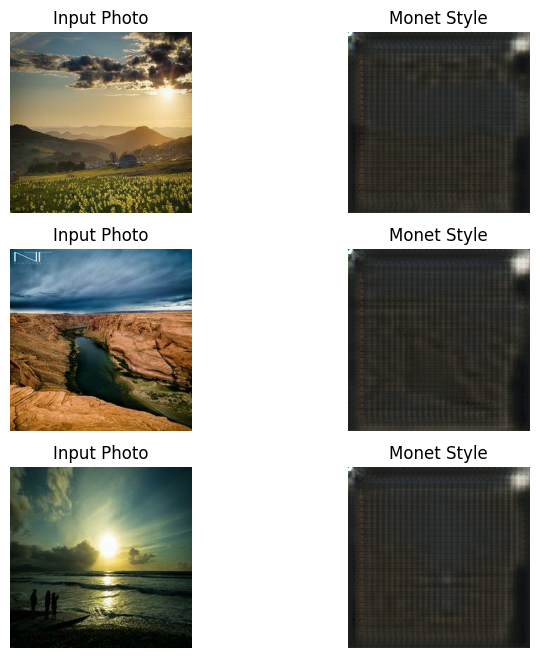

In [110]:
style_transfer_img(m_generator = monet_generator1)

The training log shows that the two generator losses have high initial value at the first epoch and continue to increase until 12th and 16th epoch separately. On the contrast, the discriminator losses start with a very small value and keep decreasing until the same epochs. The values of generator loss are approximately 14 and 10 separately in the last epoch, which is very high. On the other hand, discriminator losses have very low value. That means, the model starts to learn after 12th and 16th epoch, and the generated images are easily identified by the discriminators. Three photos and their Monet style version are displayed and the output further confirms our analysis result. Monet style photos are all black and white but the model captures some features of original photos (shapes, etc.). However, our CycleGAN fails to learn the style of Monet paintings. In the next step, the activation function of the output layer of two generator neural network will be updated from tanh function to sigmoid function aiming for improve model performance. The performance of two models will be compared and analyzed.

In [21]:
# change activation function to sigmoid.
def define_generator2(n_resnet = 9):
    input_img = keras.layers.Input(shape = [256, 256, 3])
    model = downsample(64, 4, apply_instancenorm=False)(input_img)
    model = downsample(128, 4)(model)
    model = downsample(256, 4)(model)

    for _ in range(n_resnet):
        model = resnet_block(model, 256)

    up1 = upsample(128, 4, apply_dropout = True)(model)
    up2 = upsample(64, 4, apply_dropout = True)(up1)

    init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    output = Conv2DTranspose(3, kernel_size = 4, strides = 2, padding='same', kernel_initializer=init)(up2)
    output = InstanceNormalization(axis=-1)(output)
    output_img = Activation('sigmoid')(output)

    model = Model(input_img, output_img)
    return model

In [26]:
# model 2
monet_generator2 = define_generator2()
photo_generator2 = define_generator2()
monet_discriminator2 = define_discriminator()
photo_discriminator2 = define_discriminator()

monet_generator_opt2 = Adam(2e-5, beta_1=0.5)
photo_generator_opt2 = Adam(2e-5, beta_1=0.5)

monet_discriminator_opt2 = Adam(2e-5, beta_1=0.5)
photo_discriminator_opt2 = Adam(2e-5, beta_1=0.5)

cycle_gan_model2 = CycleGan(
    monet_generator2, photo_generator2, monet_discriminator2, photo_discriminator2
)

cycle_gan_model2.compile(
    m_gen_optimizer = monet_generator_opt2,
    p_gen_optimizer = photo_generator_opt2,
    m_disc_optimizer = monet_discriminator_opt2,
    p_disc_optimizer = photo_discriminator_opt2,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

cycle_gan_model2.fit(
    tf.data.Dataset.zip((painting_data, photo_data)),
    epochs=30
)

Epoch 1/30
300/300 [==============================] - 175s 401ms/step - monet_gen_loss: 5.7322 - photo_gen_loss: 5.9846 - monet_disc_loss: 0.6363 - photo_disc_loss: 0.6286
Epoch 2/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 4.9870 - photo_gen_loss: 5.1479 - monet_disc_loss: 0.5277 - photo_disc_loss: 0.5506
Epoch 3/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 5.1580 - photo_gen_loss: 5.1691 - monet_disc_loss: 0.4043 - photo_disc_loss: 0.4733
Epoch 4/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 5.2355 - photo_gen_loss: 5.2327 - monet_disc_loss: 0.3748 - photo_disc_loss: 0.4164
Epoch 5/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 5.0474 - photo_gen_loss: 5.2377 - monet_disc_loss: 0.4507 - photo_disc_loss: 0.4066
Epoch 6/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 4.9070 - photo_gen_loss: 5.2420 - monet_disc_loss: 0

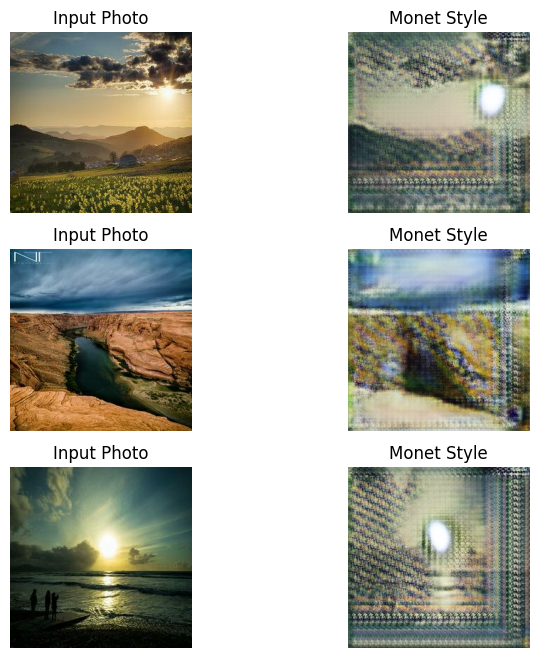

In [111]:
style_transfer_img(m_generator = monet_generator2)

After adjusting the activation function from tanh to sigmoid in the output layer of generator neural network, it's clear that the new neural network has a much better performance with respect to loss metric and generated images. Both generator loss start with a relatively lower value and their values in the last epoch are considerably lower as well. The value of discriminator loss to distinguish between real and fake Monet paintings are low and close to 0.5. That means the discriminator is guessing whether the painting is fake or not and the generator has a decent performance on fooling the discriminator. The output images also reflect that the model learnt some characteristics of Monet painting style. The neural network with sigmoid activation function performs better potentially because the input paintings and photos are scaled down to (0, 1) range and the usage of sigmoid function ensures both real and generated images have a similar distribution. However, the loss of discriminator that identifies fake photo is much lower than 0.5. It reflects that the generated photos are easily identified by photo discriminator. Considering the aim of this project is to study transferring Monet style to photos, there is no need to concern about the low ability to translate Monet paintings to real photos. It's also noticeable that the generator loss starts increasing at around the last one-third of the training process. Next, a hyperparameter tuning method will be implemented to tune the learning rate for improving the model performance.

In [65]:
# hyperparameter tuning
np.random.seed(42)
lr_choice1 = np.random.uniform(low = 2e-7, high = 2e-5, size = 1)[0]
lr_choice2 = np.random.uniform(low = 2e-5, high = 2e-3, size = 1)[0]
print(lr_choice1, lr_choice2)

7.615894353177777e-06 0.001902414326691634


In [66]:
# model 3
monet_generator3 = define_generator2()
photo_generator3 = define_generator2()
monet_discriminator3 = define_discriminator()
photo_discriminator3 = define_discriminator()

monet_generator_opt3 = Adam(lr_choice1, beta_1=0.5)
photo_generator_opt3 = Adam(lr_choice1, beta_1=0.5)
monet_discriminator_opt3 = Adam(lr_choice1, beta_1=0.5)
photo_discriminator_opt3 = Adam(lr_choice1, beta_1=0.5)

cycle_gan_model3 = CycleGan(
    monet_generator3, photo_generator3, monet_discriminator3, photo_discriminator3
)

cycle_gan_model3.compile(
    m_gen_optimizer = monet_generator_opt3,
    p_gen_optimizer = photo_generator_opt3,
    m_disc_optimizer = monet_discriminator_opt3,
    p_disc_optimizer = photo_discriminator_opt3,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

cycle_gan_model3.fit(
    tf.data.Dataset.zip((painting_data, photo_data)),
    epochs=30
)

Epoch 1/30
300/300 [==============================] - 174s 401ms/step - monet_gen_loss: 6.3603 - photo_gen_loss: 6.5449 - monet_disc_loss: 0.6360 - photo_disc_loss: 0.6738
Epoch 2/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 5.4884 - photo_gen_loss: 5.6093 - monet_disc_loss: 0.5631 - photo_disc_loss: 0.5977
Epoch 3/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 5.1632 - photo_gen_loss: 5.2996 - monet_disc_loss: 0.5349 - photo_disc_loss: 0.5567
Epoch 4/30
300/300 [==============================] - 120s 402ms/step - monet_gen_loss: 5.0243 - photo_gen_loss: 5.1880 - monet_disc_loss: 0.5209 - photo_disc_loss: 0.5137
Epoch 5/30
300/300 [==============================] - 120s 402ms/step - monet_gen_loss: 4.9971 - photo_gen_loss: 5.1246 - monet_disc_loss: 0.4643 - photo_disc_loss: 0.4780
Epoch 6/30
300/300 [==============================] - 120s 402ms/step - monet_gen_loss: 5.0468 - photo_gen_loss: 5.1253 - monet_disc_loss: 0

In [73]:
# model 4
monet_generator4 = define_generator2()
photo_generator4 = define_generator2()
monet_discriminator4 = define_discriminator()
photo_discriminator4 = define_discriminator()

monet_generator_opt4 = Adam(lr_choice2, beta_1=0.5)
photo_generator_opt4 = Adam(lr_choice2, beta_1=0.5)
monet_discriminator_opt4 = Adam(lr_choice2, beta_1=0.5)
photo_discriminator_opt4 = Adam(lr_choice2, beta_1=0.5)

cycle_gan_model4 = CycleGan(
    monet_generator4, photo_generator4, monet_discriminator4, photo_discriminator4
)

cycle_gan_model4.compile(
    m_gen_optimizer = monet_generator_opt4,
    p_gen_optimizer = photo_generator_opt4,
    m_disc_optimizer = monet_discriminator_opt4,
    p_disc_optimizer = photo_discriminator_opt4,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

cycle_gan_model4.fit(
    tf.data.Dataset.zip((painting_data, photo_data)),
    epochs=30
)

Epoch 1/30
300/300 [==============================] - 176s 400ms/step - monet_gen_loss: 4.9066 - photo_gen_loss: 5.0090 - monet_disc_loss: 0.7317 - photo_disc_loss: 0.7361
Epoch 2/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 4.5479 - photo_gen_loss: 4.5716 - monet_disc_loss: 0.6867 - photo_disc_loss: 0.6957
Epoch 3/30
300/300 [==============================] - 120s 401ms/step - monet_gen_loss: 4.4631 - photo_gen_loss: 4.4410 - monet_disc_loss: 0.6708 - photo_disc_loss: 0.6935
Epoch 4/30
300/300 [==============================] - 120s 402ms/step - monet_gen_loss: 4.4412 - photo_gen_loss: 4.3756 - monet_disc_loss: 0.6488 - photo_disc_loss: 0.6841
Epoch 5/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 4.3573 - photo_gen_loss: 4.3221 - monet_disc_loss: 0.6575 - photo_disc_loss: 0.6764
Epoch 6/30
300/300 [==============================] - 120s 400ms/step - monet_gen_loss: 4.3431 - photo_gen_loss: 4.3161 - monet_disc_loss: 0

In [74]:
# hyperparameter tuning summary
lr_choices = [lr_choice1, 2e-5 ,lr_choice2]
m_gen_loss = [4.6906, 5.4471, 5.1826]
p_gen_loss = [5.2710, 6.1662, 5.1202]
m_disc_loss = [0.4823, 0.3074, 0.4154]
p_disc_loss = [0.3238, 0.1879, 0.4831]
hp_summary = {'Learning Rate': lr_choices, 'Monet Generator Loss': m_gen_loss, 'Photo Generator Loss': p_gen_loss, 'Monet Discriminator Loss': m_disc_loss, 'Photo Discriminator Loss': p_disc_loss}

hp_summary_df = pd.DataFrame(hp_summary)
hp_summary_df.head()


,Learning Rate,Monet Generator Loss,Photo Generator Loss,Monet Discriminator Loss,Photo Discriminator Loss
0,0.000008,4.6906,5.2710,0.4823,0.3238
1,0.000020,5.4471,6.1662,0.3074,0.1879
2,0.001902,5.1826,5.1202,0.4154,0.4831


The optimized model was achieved with a learning rate of 0.000008. The Monet generator loss score is approximately 4.69 which is lower than the same score obtained by all the models trained earlier. Besides, the Monet discriminator loss is 0.4823 which is very close to 0.5. Thus, this model is selected as the final model in this study and all 7038 photos will be converted to Monet style paintings with the trained Monet style photo generator. Predictions will be evaluated with MiFID.

In [79]:
# prediction
i = 1
for img in photo_data:
    pred = monet_generator3(img, training=False)[0].numpy()
    pred = (pred * 255.0).astype(np.uint8)
    img = Image.fromarray(pred)
    img.save(os.path.join(local_path, 'pred', str(i) + '.jpg'))
    i += 1

In [103]:
# download zip file
!zip -r pred.zip pred/
files.download('/content/pred.zip')

Streaming output truncated to the last 5000 lines.
  adding: pred/3868.jpg (deflated 2%)
  adding: pred/4052.jpg (deflated 7%)
  adding: pred/6101.jpg (deflated 1%)
  adding: pred/815.jpg (deflated 1%)
  adding: pred/1641.jpg (deflated 2%)
  adding: pred/5015.jpg (deflated 1%)
  adding: pred/1520.jpg (deflated 1%)
  adding: pred/2345.jpg (deflated 1%)
  adding: pred/3082.jpg (deflated 1%)
  adding: pred/2540.jpg (deflated 1%)
  adding: pred/76.jpg (deflated 1%)
  adding: pred/5431.jpg (deflated 2%)
  adding: pred/3243.jpg (deflated 1%)
  adding: pred/4596.jpg (deflated 2%)
  adding: pred/1288.jpg (deflated 1%)
  adding: pred/6379.jpg (deflated 2%)
  adding: pred/3189.jpg (deflated 2%)
  adding: pred/3524.jpg (deflated 3%)
  adding: pred/3213.jpg (deflated 2%)
  adding: pred/5039.jpg (deflated 1%)
  adding: pred/5809.jpg (deflated 2%)
  adding: pred/2091.jpg (deflated 2%)
  adding: pred/1238.jpg (deflated 1%)
  adding: pred/1878.jpg (deflated 3%)
  adding: pred/1617.jpg (deflated 1%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

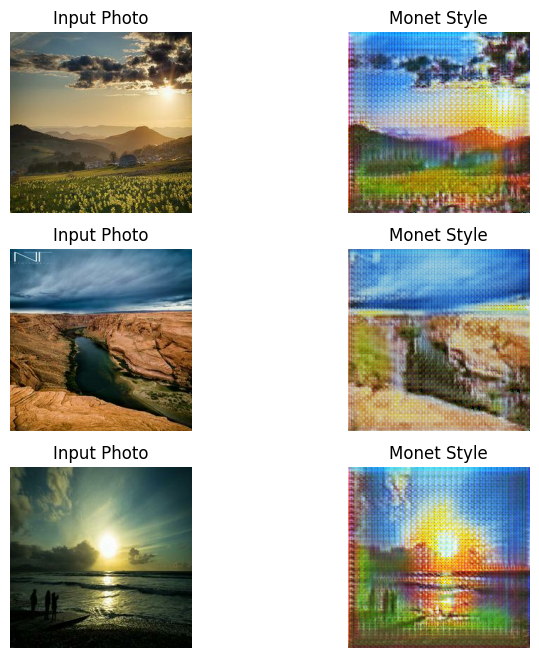

In [112]:
style_transfer_img(m_generator = monet_generator4)

Unfortunately, this Kaggle competition only supports notebook submission and it's mandatory to predict in a Kaggle notebook. Thus, MiFID score of the style transfered images is unable to be calculated. Instead, three pair of photos and their Monte style version are displayed to assist on model evaluation. The output images are more colorful compared to previous predictions. It provides evidences that the optimized model has a deeper learning on the color aspect of Monet paintings.

## Discussion

This study focused on exploring the performance of CycleGAN on style transfer task. The final model is developed through a performance-based iterative process which includes adjusting the activation function of the generator neural network and tuning learning rate. One important takeaway is that an ideal CycleGAN is expected to have a decreasing trend on generator loss and a final discriminator loss around 0.5. Also, the discriminator loss will increase if the generator loss decreases and vice versa. The expectation of an ideal model provides guidance on model training and evaluation. Additionally, the activation function of the output layer of the generator neural work needs to be carefully chosen depending on normalization methods of the input images. For example, tanh function should be set if input images are preprocessed to be in (-1, 1) and sigmoid function needs to be used instead if the input data is rescaled to the range of (0, 1). The idea is to match the distribution between input and generated images; otherwise, the model fails to learn the image features and start generating random images during the training process. There also exists rooms to further improve our neural network. With an extent of resources, more architectures including U-Net generator can be tested and explored. A wider range of hyperparameters can be tuned with random search technique to aim for improving the model performance as well.

## Resources
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook